#Build LLM

In [1]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,   # Vucabulary Size
    'ctx_len': 265,       # Context Lenghts
    'emb_dim': 768,        # Embedding dimension
    'n_heads': 12,         # Number of attention head
    'n_layers': 12,        # number of Layer
    'drop_rate': 0.1,      # Dropout rate
    'qkv_bias': False      # Query_Key_value Bias
}

## Tokenizing text


In [2]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [4]:
import tiktoken

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

we first define a train_ratio to use 90% of the data for training and the remaining 10% as validation data for model evaluation during training:

In [5]:
with open("/content/verdict.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]




torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["ctx_len"],
    stride=GPT_CONFIG_124M["ctx_len"],
    drop_last=True,
    shuffle=True
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["ctx_len"],
    stride=GPT_CONFIG_124M["ctx_len"],
    drop_last=False,
    shuffle=False
)

In [6]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])
torch.Size([2, 265]) torch.Size([2, 265])

Validation loader:
torch.Size([2, 265]) torch.Size([2, 265])


#Coding Attention Mechanisms

## A layer Normalization

In [7]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [8]:
class GELU(nn.Module):
    def __init__(self,):
        super().__init__()


    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [9]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
            nn.Dropout(cfg['drop_rate'])
        )

    def forward(self, x):
        return self.layers(x)

## Multi-head attention layer


In [10]:


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, block_size, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0 # d_out must be divisible by n_heads

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(block_size, block_size), diagonal=1)
        )


    def forward(self, x):
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        mask_unsqueezed = mask_bool.unsqueeze(0).unsqueeze(0)
        attn_scores.masked_fill_(mask_unsqueezed, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)

        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

## The transformer block

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            block_size=cfg['ctx_len'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'],
        )

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_resid = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut # Add the original input back

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x

#Build GPT-2 Model

In [12]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['ctx_len'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )                                                                                   #A

        self.final_norm = LayerNorm(cfg['emb_dim'])                                        #B
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)


    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds

        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

## Analysis Model Architecture and Size

In [13]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,426,624


In [15]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


The token embedding and output layers are very large due to the number of rows for the 50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from the total GPT-2 model count according to the weight tying:

In [16]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 123,829,248


In [17]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.61 MB


In [18]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [19]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [20]:
torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["ctx_len"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youilion diversebull incurabies relativity ° overtly Elaine legalization Pirates voyage Prior banning bur


#Pretraining on Unlabeled Data

In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [22]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [23]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [24]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size,
            top_k=25,
            temperature=1.4
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you"
)

Ep 1 (Step 000000): Train loss 9.843, Val loss 10.018
Ep 1 (Step 000005): Train loss 7.869, Val loss 8.365
Every effort moves you to the " it.      he it had--"   his had it    and     and I, that, that--.   " the had I the, the I  
Ep 2 (Step 000010): Train loss 6.850, Val loss 7.171
Ep 2 (Step 000015): Train loss 5.908, Val loss 6.724
Every effort moves you a was had he of-- was. that the that and him was the" was my" had the. , his."'t him in the of a with in that the it and the I in with. " was,,,.
Ep 3 (Step 000020): Train loss 5.894, Val loss 6.589
Every effort moves you in the in it him to I"I of a the Iis in of. G, and theI thatburn was. The a I of-- G. and I that, he it ". had G him to with of-- was
Ep 4 (Step 000025): Train loss 5.524, Val loss 6.548
Ep 4 (Step 000030): Train loss 5.653, Val loss 6.708
Every effort moves you his a he he.'s my me-- he of of a me., in he was that and-- not-- with the had it the my you it at in he had his not you a to him he was was on the in hi

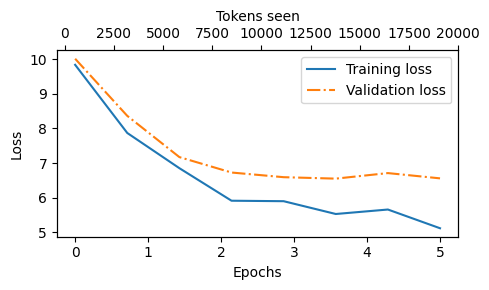

In [27]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [28]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(265, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttent

In [29]:
tokenizer = tiktoken.get_encoding("gpt2")
torch.manual_seed(123)

# Use input() function to get the text from the user
input_text = input("Enter your unfinished text: ")

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["ctx_len"],
    top_k=50,
    temperature=0.1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Enter your unfinished text: Who are
Output text:
 Who are.
" a was his, I was was, and I had a in the--and I had to have a, I had been the a he was his pictures--and the house--and the
"I, I had to have I
